In [ ]:
# Written by: Porhouy (PH) Minh and Naomi Trampe
# Last Updated Date: 03-18-2023 
# SAMPEL Group

## Comparison between path sampling methods


- This code will perform transition RETIS, FFS and cFFS on a simple potential energy surface (PES). 

- The code is constructed as follows: 

    - Performing RETIS, FFS, cFFS

    - Plot the density of configurations sampled on the PES of each method for comparison purpose

## Learning Objectives

1. Understand power and limitations of each method used. 

    - To explore this you can see for a given pes_type, how does the sampling differ between these RETIS and FFS? Given that they used the same type of op. 

    - How does sampling differ between all the methods? 


## Energy surface contours options

PES-1: $$ V(x,y) = 0.02(x^4+y^4) - 4\exp(-(x+2)^2 - (y+2)^2) - 4\exp(-(x-2)^2 - (y-2)^2) + 0.3(x-y)^2 + 0.0026 $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-1.png"> 

PES-2: $$ V(x,y) = 0.03(x^4+y^4) - 4\exp(-(x+2)^2 - (y+2)^2) - 4\exp(-(x-2)^2 - (y-2)^2) + 0.4(x-y)^2 + 4\exp(-(x^2+y^2)) - 2.1245 $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-2.png">

PES-3: $$ V(x,y) = 0.02(x^4+y^4) - 3.73\exp(-\frac{(x+2)^2}{8} - \frac{(y+2)^2}{8}) - 3.73\exp(-\frac{(x-2)^2}{8} - \frac{(y-2)^2}{8}) + 3\exp(-\frac{x^2}{2} - \frac{y^2}{15}) + 2\exp(-\frac{x^2}{2} - \frac{y^2}{2}) - 0.5085 $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-3.png">

PES-4: Müller-Brown Potential 
$$ V_{MB}(x,y) = \sum_{i=1}^{4}{A_{i}\exp([ a_{i}(x-\bar{x_{i}})^2 + b_{i}(x-\bar{x_{i}})(y-\bar{y_{i}}) + c_{i}(y-\bar{y_{i}})^2 ])} $$ 
where:

$$ A = [-8, -4, -6.8, 0.6] $$
$$ a = [-0.111, -0.111, -0.722, 0.0778] $$
$$ b = [0, 0, 1.22, 0.0667] $$
$$ c = [-1.11, -1.11, -0.722, 0.0778] $$
$$ \bar{x} = [3, 0, -1.5, -3] $$
$$ \bar{y} = [-3, -1.5, 1.5, 0] $$

<img src="https://raw.githubusercontent.com/minhx010/pathsampling-notebooks/main/PES-figures/pes-4.png">

## Choose your PES

<function matplotlib.pyplot.show(close=None, block=None)>

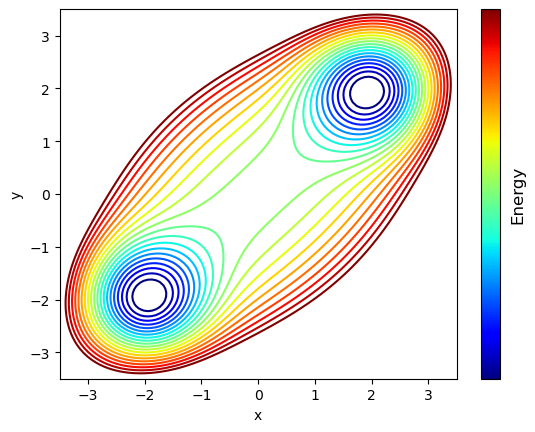

In [1]:
import numpy as np
import sys
import math
import copy
from math import exp
import langevin_dynamics as ld
import random
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm

# Select your PES type: ***** EDIT HERE *****
pes_type = 1

# Plot potential energy surface contours
N = 100
x_vec = np.linspace(-3.5, 3.5, N)
y_vec = np.linspace(-3.5, 3.5, N)
X, Y = np.meshgrid(x_vec, y_vec)
energy = np.zeros((N, N))

# Plot contours
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)
plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')
cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.xlabel('x')
plt.ylabel('y')
plt.show

## Simulation Settings

## 1) RETIS Settings

<function matplotlib.pyplot.show(close=None, block=None)>

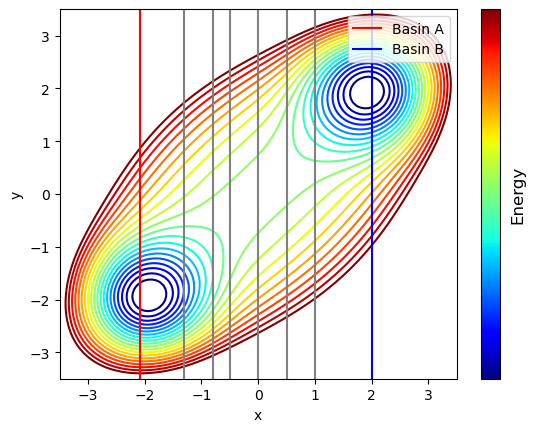

In [2]:
import RETIS as ret

# TIS settings
n_moves = 1000              # number of moves to perform for each path ensemble - path ensemble corresponding to each diff interface
op_type = 1                 # order parameter;  1:x  2:y  3:x+y
interfaces = [-1.3, -0.8, -0.5, 0.0, 0.5, 1.0, 2.0]
basinA = -2.09              # boundary of basin A; must be less than the first interface
basinB = interfaces[-1]     # basin B defined as last interface
init_coords = [-1, -1]      # initial coordinates
init_p = [0, 0]             # initial momenta
basineqlen = 5000           # basin equilibration length (steps)
basinlen = 50000            # basin simulation length
sigma = 0.5                 # standard deviation of momenta perturbation

#Langevin dynamics settings
beta = 2.5                  # 1/kT
beta_initpath = 1.5         # 1/kT
gamma = 5.0                 # friction
dt = 0.01                   # time step size

# Plot PES contours with interfaces
# Plot contours
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(x_vec[i],y_vec[j],pes_type)

plt.contour(x_vec,y_vec,energy,np.linspace(-3,3,20), cmap = 'jet')

# Plot basin boundaries

if op_type == 1:
    plt.plot(np.linspace(basinA,basinA,10),np.linspace(min(y_vec),max(y_vec),10),color='r', label='Basin A')
    plt.plot(np.linspace(basinB,basinB,10),np.linspace(min(y_vec),max(y_vec),10),color='b', label='Basin B')
elif op_type == 2:
    plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(basinA,basinA,10),color='r', label='Basin A')
    plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(basinB,basinB,10),color='b', label='Basin B')
else:
    xplot = np.linspace(min(x_vec),max(x_vec),10)
    yplmax = basinB - xplot
    yplmin = basinA - xplot
    plt.plot(xplot,yplmin,color='r', label='Basin A')
    plt.plot(xplot,yplmax,color='b', label='Basin B')

# Plot interfaces
for i in range(len(interfaces)-1):
    
    if op_type == 1:
        plt.plot(np.linspace(interfaces[i],interfaces[i],10),np.linspace(min(y_vec),max(y_vec),10), color='grey')
    elif op_type == 2:
        plt.plot(np.linspace(min(x_vec),max(x_vec),10),np.linspace(interfaces[i],interfaces[i],10), color='grey')
    else:
        xplot = np.linspace(min(x_vec),max(x_vec),10)
        yplot = interfaces[i]-xplot
        plt.plot(xplot,yplot, color='grey')    
        
cbar = plt.colorbar(cm.ScalarMappable(cmap='jet'))
cbar.set_ticks([])
cbar.set_label(label = 'Energy', size=12)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show

## Perform RETIS

           ; Performing Shoot Move 1-2, 3-4, 5-6, ...etc
            🎉 Congraulations 🎉
                    
                


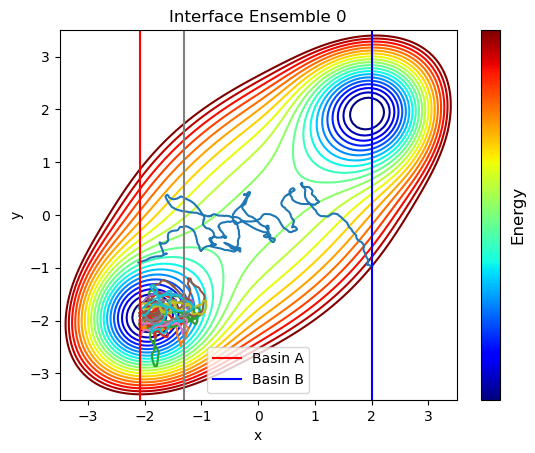

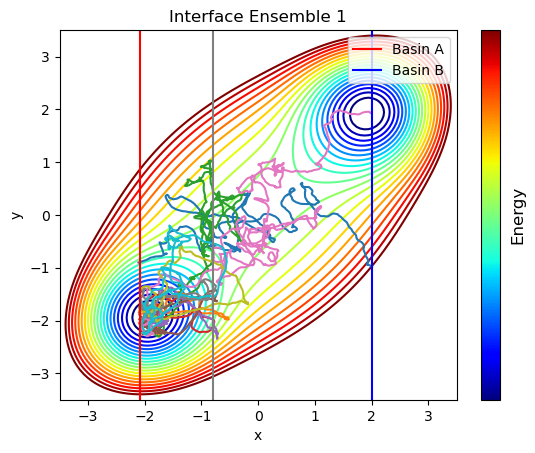

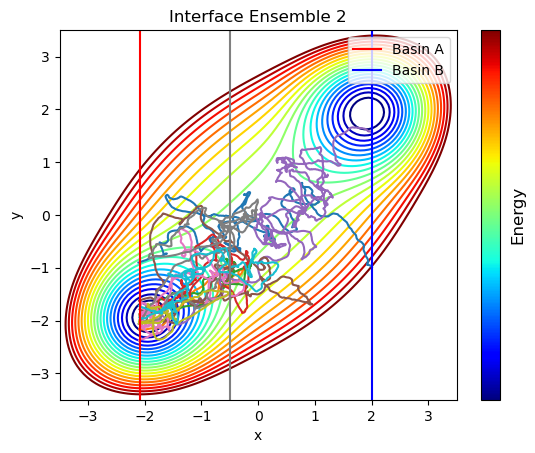

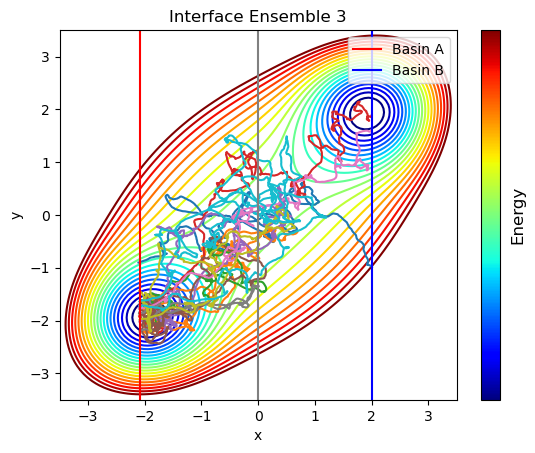

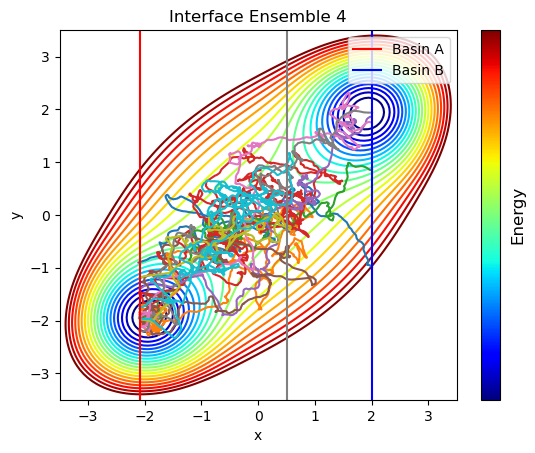

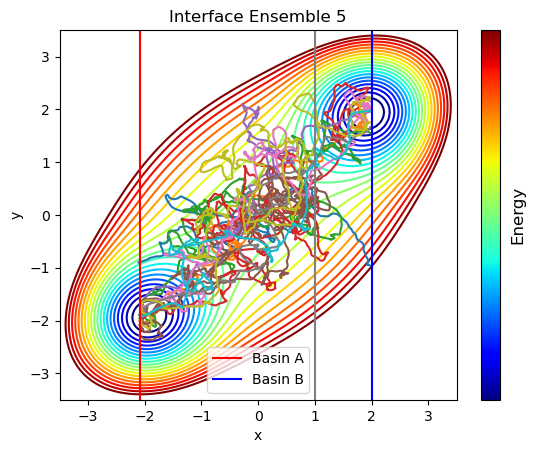

In [3]:
# Perform RETIS
ret.performretis(pes_type,op_type,interfaces,n_moves,basinA,init_coords,basineqlen,basinlen,beta,beta_initpath)

## 2) FFS Settings

## Perform FFS